# CH14 Exercises

### 9. Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
import numpy as np

In [62]:
(X_train_full, y_train_full), (X_test, y_test) = mnist = tf.keras.datasets.mnist.load_data()

X_train,X_valid = X_train_full[:45000],X_train_full[45000:]
y_train,y_valid = y_train_full[:45000],y_train_full[45000:]


X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

assert X_train.shape == (45000, 28, 28,1)
assert X_test.shape == (10000, 28, 28,1)
assert y_train.shape == (45000,)
assert y_test.shape == (10000,)

In [63]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(y_train),seed=42).batch(32).prefetch(1)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).batch(32).prefetch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32).prefetch(1)

In [83]:
aug_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05,input_shape=X_train.shape[1:]),                         
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0),width_factor=(-0.1, 0)),         
    tf.keras.layers.RandomContrast(factor=0.1),                  
    tf.keras.layers.RandomTranslation(height_factor=0.01, width_factor=0.01),       
])

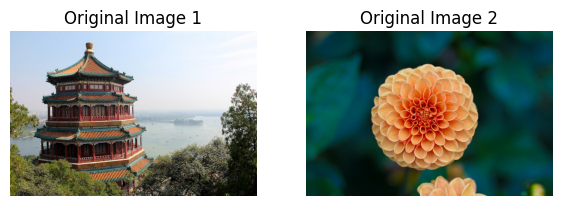



Epoch: 1




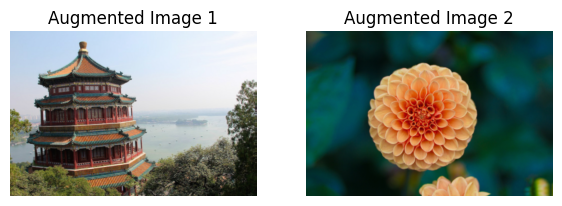



Epoch: 2




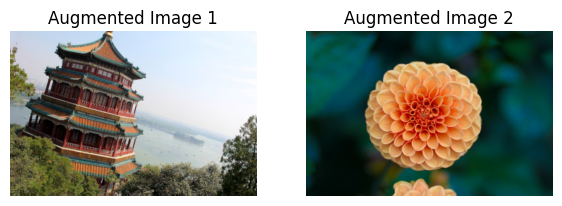



Epoch: 3




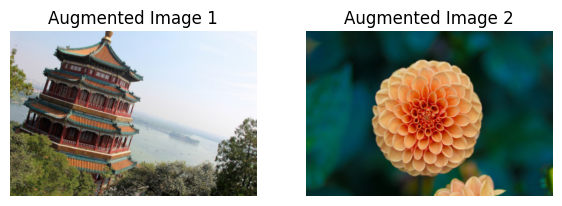

In [84]:
sample = load_sample_images()  
images = np.array(sample.images, dtype=np.float32)

# Function to apply augmentation to a batch of images
def augment_images(images, augment_layer):
    img_batch = tf.convert_to_tensor(images)
    augmented_images_batch = augment_layer(img_batch)
    return augmented_images_batch.numpy()

# Function to plot images
def plot_images(images, titles, fig_size=(7, 4)):
    plt.figure(figsize=fig_size)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img / 255.0)  
        plt.title(title)
        plt.axis('off')
    plt.show()

# Main function to visualize original images and augmented images over multiple epochs
def visualize_images(images, augment_layer, epochs=3):
    # Visualize original images only once
    plot_images(images, [f"Original Image {i+1}" for i in range(len(images))])

    for epoch in range(1, epochs + 1):
        print(f"\n\nEpoch: {epoch}\n\n")
        augmented_images = augment_images(images, augment_layer)
        plot_images(augmented_images, [f"Augmented Image {i+1}" for i in range(len(images))])

visualize_images(images, aug_layers, epochs=3)

In [99]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [100]:
num_classes=10

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255, input_shape=X_train.shape[1:]),
    aug_layers,
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='leaky_relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='leaky_relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='leaky_relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),  # Add Dropout
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [101]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_20 (Sequential)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,634 (369.66 KB)

 Trainable params: 94,186 (367.91 KB)

 Non-trainable params: 448 (1.75 KB)

In [102]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optim,metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,         
    restore_best_weights=True  
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',  
    monitor='val_loss',         
    save_best_only=True,       
    mode='min',                
    verbose=1                  
)

In [88]:
history= model.fit(train_dataset, validation_data=valid_dataset, epochs=30, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6650 - loss: 0.9987
Epoch 1: val_loss improved from inf to 0.12014, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6651 - loss: 0.9984 - val_accuracy: 0.9634 - val_loss: 0.1201
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9383 - loss: 0.2127
Epoch 2: val_loss improved from 0.12014 to 0.06939, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9383 - loss: 0.2127 - val_accuracy: 0.9776 - val_loss: 0.0694
Epoch 3/30
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9550 - loss: 0.1450
Epoch 3: val_loss improved from 0.06939 to 0.06185, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9551 - loss: 0.1450 - val_accuracy: 0.9810 - val_loss: 0.0618
Epoch 4/30
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9631 - loss: 0.1239
Epoch 4: val_loss improved from 0.06185

In [89]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9906 - loss: 0.0282
Test accuracy: 0.9917


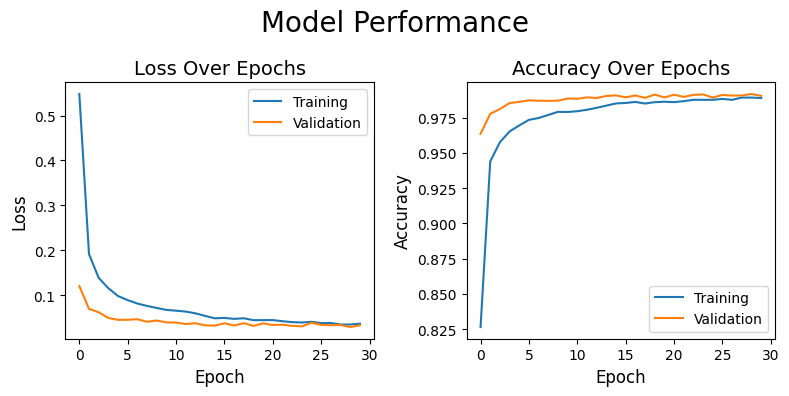

In [96]:
history_dict = history.history
metrics_to_plot = {
    'Loss': ('loss', 'val_loss'),
    'Accuracy': ('accuracy', 'val_accuracy'),
}

fig = plt.figure(figsize=(8, 4))

for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics_to_plot.items(), 1):
    plt.subplot(1, 2, i)
    plt.plot(history_dict[train_metric], label='Training')
    plt.plot(history_dict[val_metric], label='Validation')
    plt.title(f'{metric_name} Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend()

fig.suptitle('Model Performance',size=20)
fig.tight_layout()
plt.show()

---